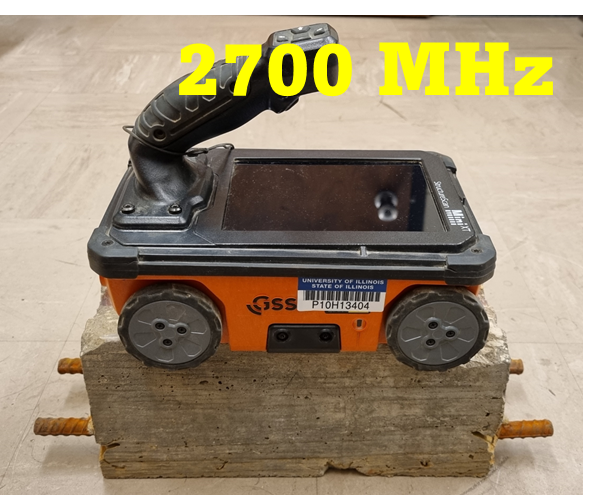

# Packages and Utility functions

#### All necessary packages and gprMax need to be installed to run the following codes

In [1]:
import numpy as np; 
import pandas as pd; 
import matplotlib.pyplot as plt; 
plt.rcParams['figure.figsize'] = (10, 2);
from gprMax.utilities import detect_check_gpus; 
from gprMax.gprMax import api; 
import h5py; 
detect_check_gpus([1]);
import os; 
import torch
import time; 
from IPython.display import clear_output; 
os.getcwd(); 
from GPUtil import showUtilization as gpu_usage
from numba import cuda; 
import gc; 
import pycuda.driver; 
import random; 
from scipy.signal import hilbert
from bayes_opt import BayesianOptimization; 

def free_gpu_cache():
    gc.collect(); 
    torch.cuda.empty_cache(); 
    cuda.select_device(1); 
    cuda.close(); 
    cuda.select_device(1); 
    gpu_usage()
free_gpu_cache()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

| ID | GPU | MEM |
------------------
|  0 | 10% |  1% |
|  1 |  0% |  5% |


In [2]:
## Function to 
#   1. MATCH LENGTH of experimental and numerical signal, 
#   2. Perform HILBERT TRANSFORM to get amplitude envelope and
#   3. NORMALIZE both experimental and numerical A-scans

def signal_length_matching(smaller,longer):
    # Changing shape of the experimental signal
    original_vector = smaller
    new_size = longer.shape[0]                                          # Specify the desired new size
    original_indices = np.arange(original_vector.size)                  # Create an array of indices for the original vector
    new_indices = np.linspace(0, original_indices.max(), new_size)      # Create an array of indices for the new vector
    smaller_new = np.interp(new_indices, original_indices, original_vector) # Perform linear interpolation

    # Normalize and hilbert transform the signals
    longer      = np.abs(hilbert(longer));          smaller_new = np.abs(hilbert(smaller_new))              # HILBERT TRANSFORM    
    longer   = longer/(np.max(abs(longer)));        smaller_new  = smaller_new/(np.max(abs(smaller_new)))   # Normalize
    
    clear_output()
    return smaller_new, longer

# Material Property estimation

### A-scans from Experiment

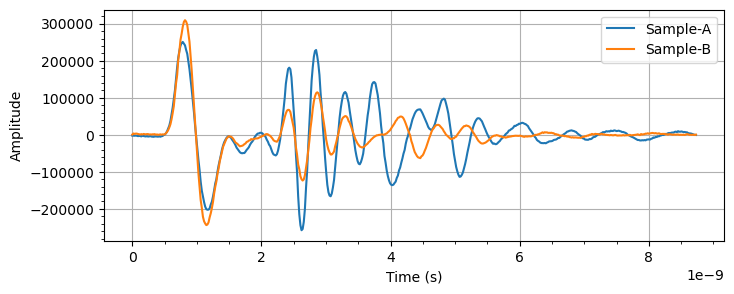

In [3]:
data = pd.read_csv('FILE__010.CSV')
# First 20 scans are over Sample-A and last 20 scans are over sample B

A_exp = data.iloc[5:15].mean()[:];              # Taking mean of 10 A-scans of sample-A      
A_exp2 = data.iloc[25:35].mean()[:];            # Taking mean of 10 A-scans of sample-B

A_exp = A_exp - np.mean(A_exp);                 # Subtracting mean amplitude - Sample-A
A_exp2 = A_exp2 - np.mean(A_exp2)               # Subtracting mean amplitude - Sample-B

tw= 8.73e-9; 
t_exp = np.linspace(0, tw, A_exp.shape[0])

plt.figure(figsize=(8,3))
plt.plot(t_exp,A_exp, label ='Sample-A'); 
plt.plot(t_exp,A_exp2, label ='Sample-B');
plt.xlabel('Time (s)')
plt.ylabel('Amplitude') 
plt.legend();  
plt.minorticks_on(); 
plt.grid(); 
plt.show()

### A-scan from 2D FDTD simulation

In [4]:
tw=t_exp[-1];
def model_miniXT_2D(p1,c1, p2, c2, dd):
    b=0.02
    X=0.2; Y=0.2; dx=0.001; Z=dx; dep = 0.13; gpr_Y = dep+b+dd; freq = 1.44e9; rebar_dia = 0.01; Tx=X/2-0.01
    with open("Concrete.in", "w") as f:
        f.write(f"#title: Concrete")  
        f.write(f"\n#domain: {X} {Y} {Z}") 
        f.write(f"\n#dx_dy_dz: {dx} {dx} {dx}") 
        f.write(f"\n#time_window: {tw}")
        
        f.write(f"\n#material: {p1} {c1} 1 0 mat1")         # Material properties of concrete
        f.write(f"\n#material: {32} {0.01} 1 0 mat2")       # Material below the concrete. Properties were found by optimization
        f.write(f"\n#material: {p2} {c2} 1 0 mat3")         # Material properties of radar box in simulation
        
        f.write(f"\n#waveform: gaussian 1 {freq} my_wave")
        f.write(f"\n#hertzian_dipole: z {Tx} {gpr_Y} 0 my_wave")
        f.write(f"\n#rx: {Tx+0.062} {gpr_Y} 0")

        f.write(f"\n#box: 0 {b} 0 {X} {dep+b} {Z} mat1")
        f.write(f"\n#box: 0 {dep+b} 0 {X} {dep+b+2*dd} {Z} mat3") 
        f.write(f"\n#cylinder: {X/2-0.065/2} {0.029+b} 0 {X/2-0.065/2} {0.029+b} {Z} {rebar_dia} pec")
        f.write(f"\n#cylinder: {X/2+0.065/2} {0.029+b} 0 {X/2+0.065/2} {0.029+b} {Z} {rebar_dia} pec")
        f.write(f"\n#box: 0 {b-.01} 0 {X} {b} {Z} mat2")
        
        f.write(f"\n#geometry_view: 0 0 0 {X} {Y} {Z} {dx} {dx} {dx} Concrete n\n")
        f.close()

    api("Concrete.in", geometry_only=False, gpu=[1])
    hf2 = h5py.File("Concrete.out", 'r', libver='latest', swmr=True)
    Ascan = hf2['rxs/rx1/Ez'][:]
    hf2.close()
    free_gpu_cache();
    clear_output()
    return Ascan

### Bayesian Optimization for estimating concrete material properties

In [5]:
def mae_func(p1,c1):
    sim = model_miniXT_2D(p1,               # p1 = Permittivity of concrete
                          c1,               # c1 = Conductivity of concrete (S/m)
                          p2=1.356,         # p2 = 'ε_g' in the paper  
                          c2=0.012,         # c2 = 'σ_g' in the paper (S/m)   
                          dd=0.01           # dd=d_g [GPR was 1 cm closer to the sample beacause the wheel was not on top of the sample. Hence, dd was 0.01 instead of the actual value:0.02]
                          )          
    vector1,vector2 = signal_length_matching(A_exp2,sim)    # A_exp2 is for Sample B. Here, estimating properties of sample B. Just change to A_exp for sample-A 
    
    vector2 = np.array(vector2)
    vector2 = vector2/(np.max(abs(vector2))) 
    result1 = -100*np.sqrt(np.sum((vector1 - vector2)**2))/(np.sqrt(np.sum(vector1**2)))
    
    return result1

bounds = {'p1':(1,15), 
          'c1':(0,0.1)
          } 
optimizer = BayesianOptimization(f=mae_func, 
                                 pbounds=bounds, 
                                 allow_duplicate_points=True
                                 )

optimizer.maximize(init_points=30, n_iter=20)
print("Optimization completed successfully.");
print(optimizer.max)

| 50        | -27.7     | 0.09766   | 7.633    

 |
Optimization completed successfully.
{'target': -23.710649496324557, 'params': {'c1': 0.06262755824433826, 'p1': 8.082887981314478}}


# Forward simulation with predicted parameters

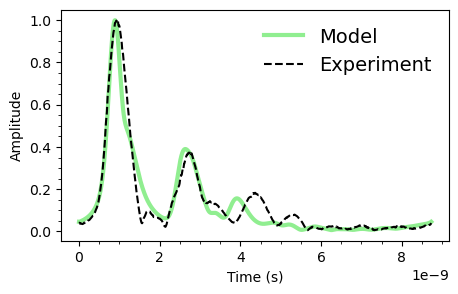

In [6]:
# Define the optimized parameter values
p1 = optimizer.max['params']['p1']; 
c1 = optimizer.max['params']['c1'];  

sim = model_miniXT_2D(p1=p1,
                      c1=c1,
                      p2=1.356, 
                      c2=0.012, 
                      dd=0.01
                      )

t_vec = np.linspace(0, tw, sim.shape[0])

a, b = signal_length_matching(A_exp2,sim)           # Change to A_exp for sample-A

plt.figure(figsize=(5, 3), dpi=100)
plt.plot(t_vec, b, label='Model', linestyle='-', color='lightgreen', linewidth=3); 
plt.plot(t_vec, a, label='Experiment', linestyle='--', color='black', linewidth=1.5);  
plt.xlabel('Time (s)');   
plt.ylabel('Amplitude'); 
plt.minorticks_on(); 
plt.legend(loc='best', frameon=False, fontsize=14);
plt.show()